In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version
import matplotlib

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='random.gsd')

mc = hoomd.hpmc.integrate.Sphere()
mc.shape['A'] = dict(diameter=0.1)
simulation.operations.integrator = mc

In [4]:
rho = simulation.state.N_particles / simulation.state.box.volume

In [5]:
r = 0.05 
V_particle = math.pi * ((r) ** 3) * (4/3)
initial_volume_fraction = (
    simulation.state.N_particles * V_particle / simulation.state.box.volume
)
initial_volume_fraction

2.8269023158027074e-05

In [6]:
(simulation.state.box.volume) ** (1/3)

8.399999618530272

In [7]:
mc = hoomd.hpmc.integrate.Sphere(default_d=0.3, default_a=0.4)
mc.shape["A"] = dict(diameter=0.1)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  0.1


In [8]:
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.57
final_box.volume = simulation.state.N_particles * V_particle / final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(
    trigger=hoomd.trigger.Periodic(10), target_box=final_box
)

In [9]:
# simulation.operations.updaters.append(compress)

In [10]:
periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    trigger=periodic,
    moves=['d'],
    target=0.2,
    max_translation_move=0.1,
)
simulation.operations.tuners.append(tune)

In [11]:
#while not compress.complete and simulation.timestep < 1e6:
simulation.run(1000)

In [12]:
mc.type_shapes

[{'type': 'Sphere', 'diameter': 0.1}]

In [13]:
#if not compress.complete:
    #message = 'Compression failed to complete'
    #raise RuntimeError(message)

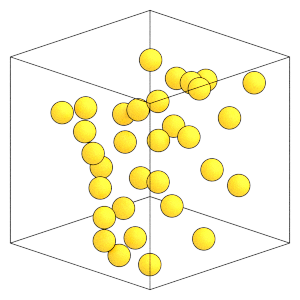

In [14]:
render(simulation.state.get_snapshot())

In [15]:
compressed_volume_fraction = (
    simulation.state.N_particles * V_particle / simulation.state.box.volume
)
compressed_volume_fraction

2.8269023158027074e-05

In [16]:
L_new = (simulation.state.box.volume) ** (1/3) 
print(f"New Box Length:", L_new)

New Box Length: 8.399999618530272
